In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
from tqdm.notebook import tqdm

import wandb

In [2]:
# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Dataset and Dataloader

In [3]:
class CardImageDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
    @property
    def classes(self):
        return self.data.classes

In [4]:
dataset = CardImageDataset(
    data_dir = '/kaggle/input/cards-image-datasetclassification/train'
)

In [5]:
len(dataset)

7624

41


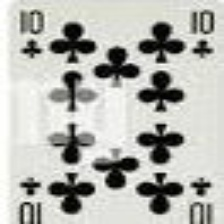

In [6]:
image, label = dataset[6000]
print(label)
image

In [7]:
# Dictionary associating target values with folder names
data_dir = '/kaggle/input/cards-image-datasetclassification/train'
target_to_class = {v: k for k, v in ImageFolder(data_dir).class_to_idx.items()}
print(target_to_class)

{0: 'ace of clubs', 1: 'ace of diamonds', 2: 'ace of hearts', 3: 'ace of spades', 4: 'eight of clubs', 5: 'eight of diamonds', 6: 'eight of hearts', 7: 'eight of spades', 8: 'five of clubs', 9: 'five of diamonds', 10: 'five of hearts', 11: 'five of spades', 12: 'four of clubs', 13: 'four of diamonds', 14: 'four of hearts', 15: 'four of spades', 16: 'jack of clubs', 17: 'jack of diamonds', 18: 'jack of hearts', 19: 'jack of spades', 20: 'joker', 21: 'king of clubs', 22: 'king of diamonds', 23: 'king of hearts', 24: 'king of spades', 25: 'nine of clubs', 26: 'nine of diamonds', 27: 'nine of hearts', 28: 'nine of spades', 29: 'queen of clubs', 30: 'queen of diamonds', 31: 'queen of hearts', 32: 'queen of spades', 33: 'seven of clubs', 34: 'seven of diamonds', 35: 'seven of hearts', 36: 'seven of spades', 37: 'six of clubs', 38: 'six of diamonds', 39: 'six of hearts', 40: 'six of spades', 41: 'ten of clubs', 42: 'ten of diamonds', 43: 'ten of hearts', 44: 'ten of spades', 45: 'three of clu

In [8]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

data_dir = '/kaggle/input/cards-image-datasetclassification/train'
dataset = CardImageDataset(data_dir, transform)

In [9]:
image, label = dataset[100]
image.shape

torch.Size([3, 128, 128])

In [10]:
# iterate over dataset
for image, label in dataset:
    break

### Dataloaders

* Batching dataset

In [11]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [12]:
for images, labels in dataloader:
    break

In [13]:
images.shape, labels.shape

(torch.Size([32, 3, 128, 128]), torch.Size([32]))

In [14]:
labels

tensor([16, 15, 29,  2, 24, 46, 38, 18, 45, 35, 43,  2,  9, 23, 32, 38,  2, 27,
        15, 24,  4, 38, 20, 23, 45, 36, 12, 40, 19, 48, 30,  4])

## Model

timm - readily available architecture for img classification

In [15]:
class CardClassifier(nn.Module):
    def __init__(self, num_classes=53):
        super(CardClassifier, self).__init__()
        
        self.base_model = timm.create_model('efficientnet_b0', pretrained=True)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])
        
        enet_out_size = 1280
        # making classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(enet_out_size, num_classes)
        )
    
    def forward(self, x):
        # connect the parts and return output
        x = self.features(x)
        output = self.classifier(x)
        return output

In [16]:
model = CardClassifier(num_classes=53)
print(str(model)[:500])

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

CardClassifier(
  (base_model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
 


In [17]:
example = model(images)
example.shape # [batch_size, num_classes]

torch.Size([32, 53])

## Training Loop

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [19]:
criterion(example, labels)
print(example.shape, labels.shape)

torch.Size([32, 53]) torch.Size([32])


### Setup Datasets

In [32]:
config = dict(
    epochs=6,
    classes=53,
#     kernels=[16, 32],
    batch_size=128,
    learning_rate=0.001,
    dataset="cards-imagedatasetclassification",
    architecture="CNN")

In [21]:
wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [29]:
def train(model, loader, criterion, optimizer, config):
    # Tell wandb to watch what the model gets up to: gradients, weights, and more!
    wandb.watch(model, criterion, log="all", log_freq=10)

    # Run training and track with wandb
    total_batches = len(loader) * config.epochs
    example_ct = 0  # number of examples seen
    batch_ct = 0
    for epoch in tqdm(range(config.epochs), desc='Training loop'):
        for _, (images, labels) in enumerate(loader):

            loss = train_batch(images, labels, model, optimizer, criterion)
            example_ct +=  len(images)
            batch_ct += 1

            # Report metrics every 25th batch
            if ((batch_ct + 1) % 25) == 0:
                train_log(loss, example_ct, epoch)

def train_batch(images, labels, model, optimizer, criterion):
    images, labels = images.to(device), labels.to(device)
    
    # Forward pass ➡
    outputs = model(images)
    loss = criterion(outputs, labels)
    
    # Backward pass ⬅
    optimizer.zero_grad()
    loss.backward()

    # Step with optimizer
    optimizer.step()

    return loss

In [23]:
def model_pipeline(hyperparameters):

    # tell wandb to get started
    with wandb.init(project="Cards-Image-Classifier", config=hyperparameters):
      # access all HPs through wandb.config, so logging matches execution!
      config = wandb.config

      # make the model, data, and optimization problem
      model, train_loader, val_loader, test_loader, criterion, optimizer = make(config)
#       print(model)

      # and use them to train the model
      train(model, train_loader, criterion, optimizer, config)

      # and test its final performance
      test(model, test_loader)

    return model

In [24]:
def make(config):
    # Make the data
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
    ])

    train_folder = '../input/cards-image-datasetclassification/train/'
    valid_folder = '../input/cards-image-datasetclassification/valid/'
    test_folder = '../input/cards-image-datasetclassification/test/'

    train_dataset = CardImageDataset(train_folder, transform=transform)
    val_dataset = CardImageDataset(valid_folder, transform=transform)
    test_dataset = CardImageDataset(test_folder, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)    

    # Make the model
    model = CardClassifier(num_classes=config.classes).to(device)

    # Make the loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(
        model.parameters(), lr=config.learning_rate)
    
    return model, train_loader, val_loader, test_loader, criterion, optimizer

In [25]:
def train_log(loss, example_ct, epoch):
    # Where the magic happens
    wandb.log({"epoch": epoch, "loss": loss}, step=example_ct)
    print(f"Loss after {str(example_ct).zfill(5)} examples: {loss:.3f}")

In [34]:
def test(model, test_loader):
    model.eval()

    # Run the model on some test examples
    with torch.no_grad():
        correct, total = 0, 0
        for images, labels in tqdm(test_loader, desc='Test loop'):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print(f"Accuracy of the model on the {total} " +
              f"test images: {correct / total:%}")
        
        wandb.log({"test_accuracy": correct / total})

    # Save the model in the exchangeable ONNX format
    torch.onnx.export(model, images, "model.onnx")
    wandb.save("model.onnx")

In [37]:
%%time
# Build, train and analyze the model with the pipeline
model = model_pipeline(config)

Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Loss after 03072 examples: 1.838
Loss after 06272 examples: 0.701
Loss after 09416 examples: 0.560
Loss after 12616 examples: 0.420
Loss after 15760 examples: 0.241
Loss after 18960 examples: 0.312
Loss after 22160 examples: 0.453
Loss after 25304 examples: 0.170
Loss after 28504 examples: 0.135
Loss after 31648 examples: 0.049
Loss after 34848 examples: 0.141
Loss after 38048 examples: 0.137
Loss after 41192 examples: 0.103
Loss after 44392 examples: 0.090


Test loop:   0%|          | 0/3 [00:00<?, ?it/s]

Accuracy of the model on the 265 test images: 93.207547%


epoch,▁▁▂▂▄▄▄▅▅▇▇▇██
loss,█▄▃▂▂▂▃▁▁▁▁▁▁▁
test_accuracy,▁
epoch,5
loss,0.08992
test_accuracy,0.93208


CPU times: user 3min 36s, sys: 3.79 s, total: 3min 40s
Wall time: 2min 53s


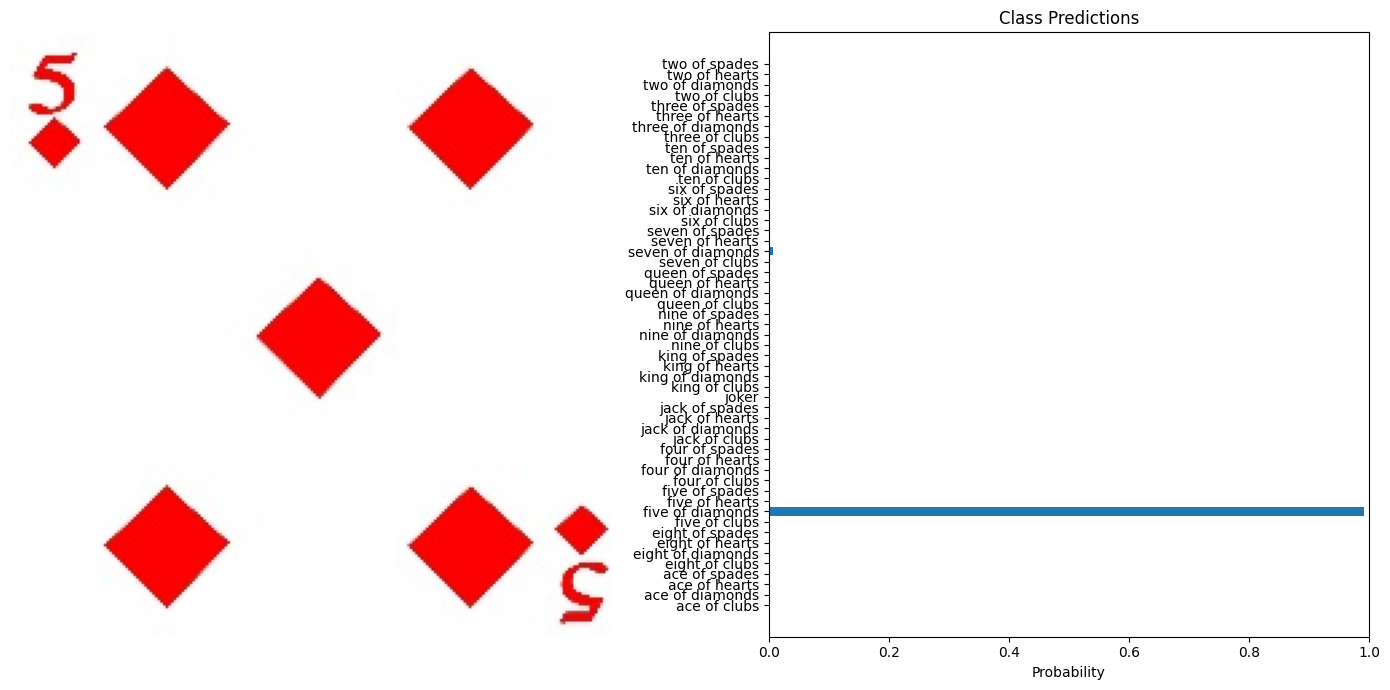

In [38]:
# Evaluating results
import torchvision.transforms as transforms
from PIL import Image

# load and preprocess the image
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    return image, transform(image).unsqueeze(0)
    
# predict using the model
def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        
    return probabilities.cpu().numpy().flatten()

# Visualization
def visualize_predictions(original_image, probabilities, class_names):
    fig, axarr = plt.subplots(1, 2, figsize=(14, 7))
    
    # Display image
    axarr[0].imshow(original_image)
    axarr[0].axis("off")
    
    # Display predictions
    axarr[1].barh(class_names, probabilities)
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Class Predictions")
    axarr[1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

# Example usage
test_image = "/kaggle/input/cards-image-datasetclassification/test/five of diamonds/2.jpg"
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

original_image, image_tensor = preprocess_image(test_image, transform)
probabilities = predict(model, image_tensor, device)

# Assuming dataset.classes gives the class names
class_names = dataset.classes 
visualize_predictions(original_image, probabilities, class_names)

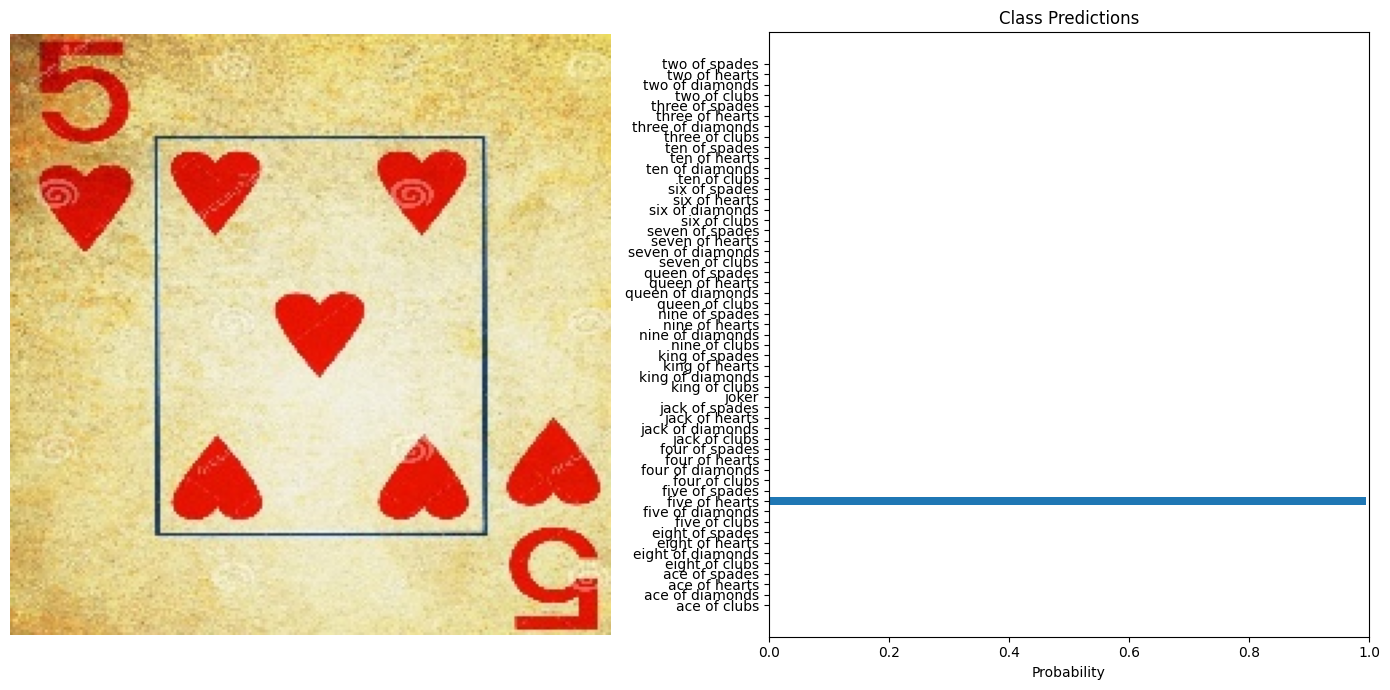

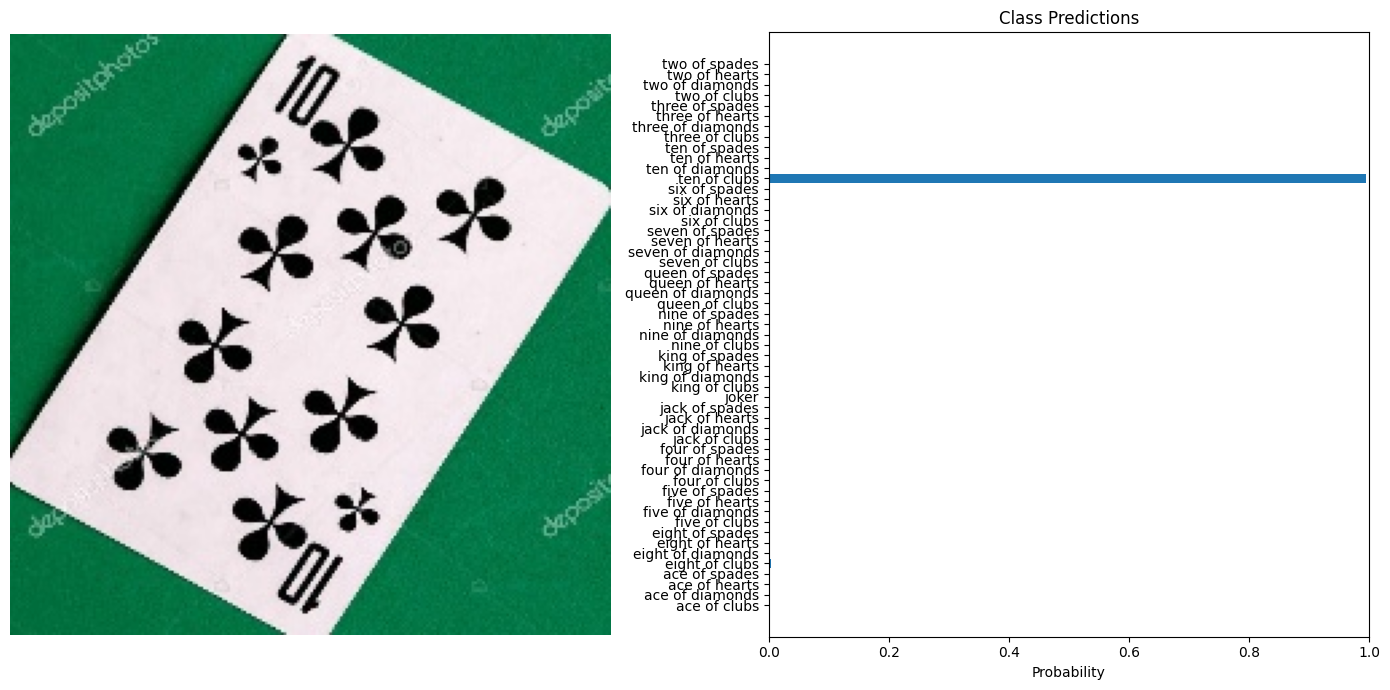

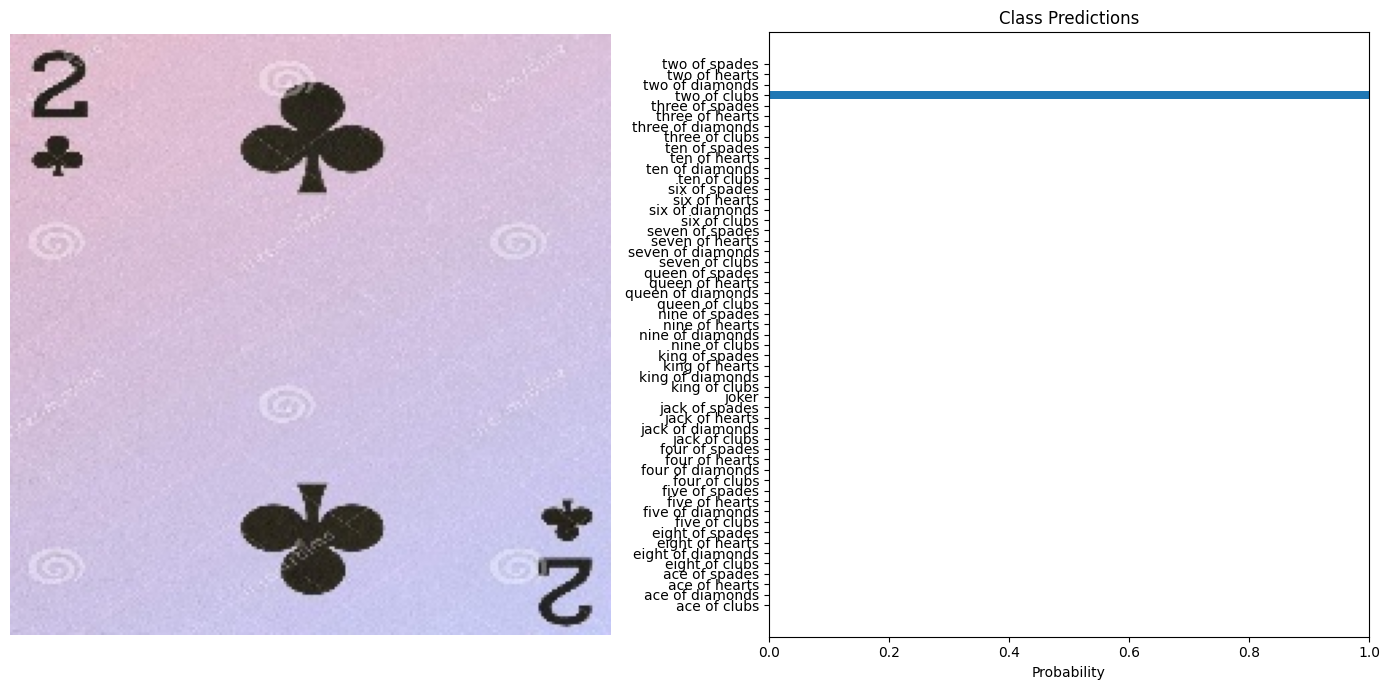

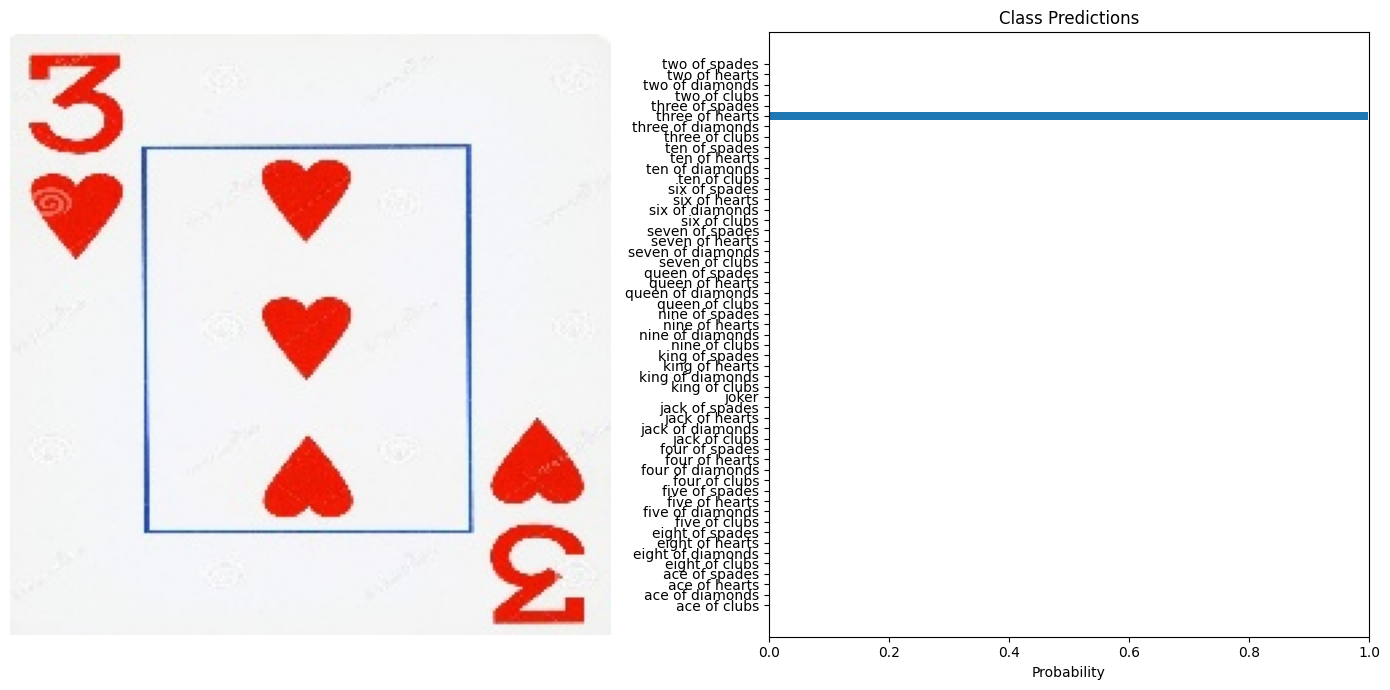

AttributeError: 'NoneType' object has no attribute '_log'

In [39]:
from glob import glob
test_images = glob('../input/cards-image-datasetclassification/test/*/*')
test_examples = np.random.choice(test_images, 10)

for example in test_examples:
    original_image, image_tensor = preprocess_image(example, transform)
    probabilities = predict(model, image_tensor, device)

    # Assuming dataset.classes gives the class names
    class_names = dataset.classes 
    visualize_predictions(original_image, probabilities, class_names)